# Physics-informed neural networks for the Covid19 pandemic

In [1]:
import numpy
import pandas
import matplotlib.pyplot as plt

import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

from src.data import SirModel
from src.visualisation import plot_param_process, plot_progress, plot_error

In [2]:
save_dir = '../figures/covid/pinn'

## Covid19 pandemic
First of all load the data of the Covid 19 pandemic in Germany between 06.05.2020 and 11.04.2022.

In [3]:
df_sir = pandas.read_csv("../data/covid19_sir.csv", index_col=0)
df_sir

,susceptible,infected,removed,vaccinated,population
06.05.2020,83035193.0,5980.0,158827.0,0.0,83200000.0
07.05.2020,83033909.0,5705.0,160386.0,0.0,83200000.0
08.05.2020,83032700.0,5394.0,161906.0,0.0,83200000.0
09.05.2020,83031449.0,5703.0,162848.0,0.0,83200000.0
10.05.2020,83030782.0,5715.0,163503.0,0.0,83200000.0
...,...,...,...,...,...
07.04.2022,60934212.0,1040481.0,21225307.0,59615114.0,83200000.0
08.04.2022,60758949.0,982220.0,21458831.0,59623432.0,83200000.0
09.04.2022,60608274.0,949500.0,21642226.0,59627259.0,83200000.0
10.04.2022,60552803.0,912992.0,21734205.0,59628513.0,83200000.0


Generate the a Sir model with an identical number of data $N$, end time $T$ and initial condition.
The parameters are chosen randomly.
Then the data can be replaced by by the observations from the covid 19 pandemic.

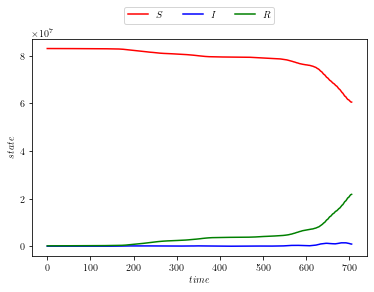

In [4]:
sir = SirModel(number_of_data=706,
               end_time=705,
               param = {'beta': 0.155, 'gamma': 1/7},
               initial_condition={'t': 0, 'y_1': 83029213.0, 'y_2': 5980.0, 'y_3': 164807.0})

new_sir_data = df_sir.reset_index().rename(columns={'susceptible': 'y_1', 'infected': 'y_2','removed': 'y_3'})[['y_1', 'y_2','y_3']]
sir.data = new_sir_data
sir.plot_data()

In [5]:
plt.rcParams.update({'font.size': 30,
                     'figure.figsize': (16, 8),
                     'text.usetex': True,
                     'text.latex.preamble': r'\usepackage{lmodern}', 
                     'font.weight': 'bold', 
                     "axes.labelweight": "bold"})

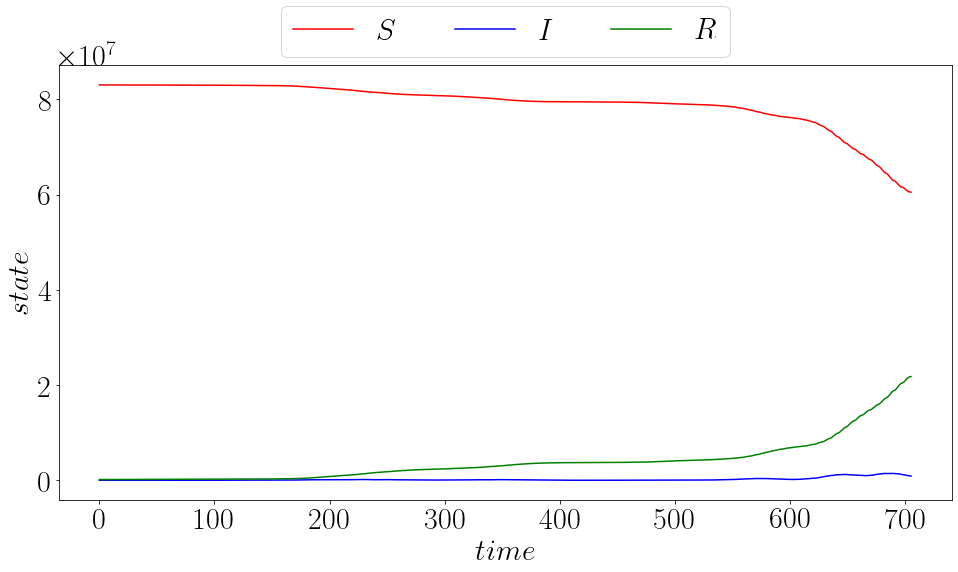

In [6]:
sir.plot_data(save_dir=save_dir)
sir.plot_data()

## Physics-informed neural network
Since the data are already available, the physics-informed neural network can now be created.

In [7]:
from src.pinn import PhysicsInformedNeuralNet

Using backend: pytorch



In [8]:
pinn = PhysicsInformedNeuralNet(sir)

population: 83200000.0


Now it just needs to be trained.

In [9]:
loss_history = pinn.train(epochs=1000, display_every=100)

Compiling model...
'compile' took 0.000089 s

Training model...

Step      Train loss                                                                                    Test loss                                                                                     Test metric
0         [2.28e-04, 1.97e-02, 1.88e-02, 6.89e+15, 3.58e+07, 2.72e+10, 6.28e+15, 1.66e+11, 3.47e+13]    [2.28e-04, 1.97e-02, 1.88e-02, 6.89e+15, 3.58e+07, 2.72e+10, 6.28e+15, 1.66e+11, 3.47e+13]    []  
100       [7.01e-07, 1.50e-03, 1.51e-03, 6.89e+15, 3.56e+07, 2.72e+10, 6.28e+15, 1.66e+11, 3.47e+13]    [7.01e-07, 1.50e-03, 1.51e-03, 6.89e+15, 3.56e+07, 2.72e+10, 6.28e+15, 1.66e+11, 3.47e+13]    []  
200       [3.27e-07, 2.29e-07, 2.45e-07, 6.89e+15, 3.54e+07, 2.72e+10, 6.28e+15, 1.66e+11, 3.47e+13]    [3.27e-07, 2.29e-07, 2.45e-07, 6.89e+15, 3.54e+07, 2.72e+10, 6.28e+15, 1.66e+11, 3.47e+13]    []  
300       [1.40e-07, 7.91e-08, 8.12e-08, 6.89e+15, 3.53e+07, 2.71e+10, 6.28e+15, 1.66e+11, 3.47e+13]    [1.40e-07, 7

Subsequently, the learning process can be visualised by plotting the development of the loss function per Epoch.

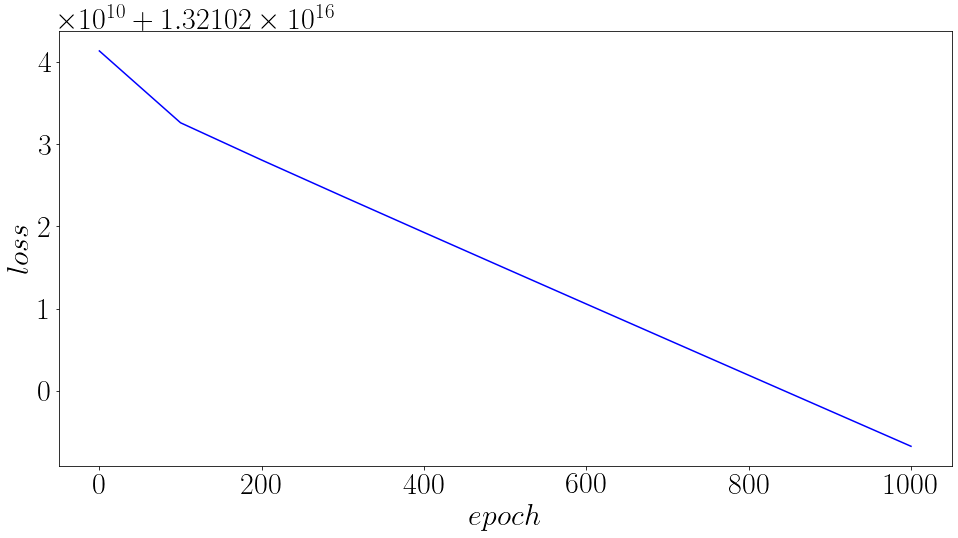

In [10]:
plt.plot(loss_history.steps, sum(numpy.array(loss_history.loss_train).T), 'b-')
plt.ylabel(r'$loss$')
plt.xlabel(r'$epoch$')
plt.savefig(f"{save_dir}/covid_pinn_loss", dpi=300)
plt.show()

After that, we look at how well the states were predicted. As an aid, the predictions can be presented together with the observations and the underlying true values.

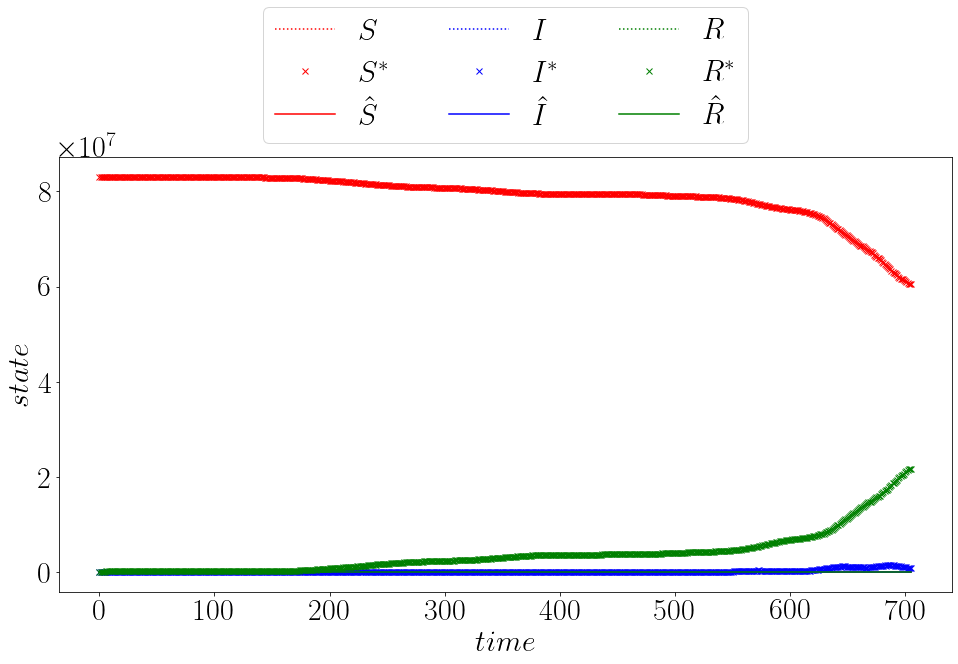

save figure to ../figures/covid/pinn/covid_pinn_progress


In [11]:
plot_progress(time=pinn.input_data['t'],
              observation=pinn.differential_equation.data,
              true=sir.data,
              prediction=pinn.predict(pinn.input_data['t']), 
              variables={'y_1': 'S', 'y_2': 'I', 'y_3': 'R'})
plot_progress(time=pinn.input_data['t'],
              observation=pinn.differential_equation.data,
              true=sir.data,
              prediction=pinn.predict(pinn.input_data['t']), 
              variables={'y_1': 'S', 'y_2': 'I', 'y_3': 'R'}, 
              save_path=f"{save_dir}/covid_pinn_progress")

Finally, we check how well the parameter estimation worked by plotting the development of the parameters over the epochs.

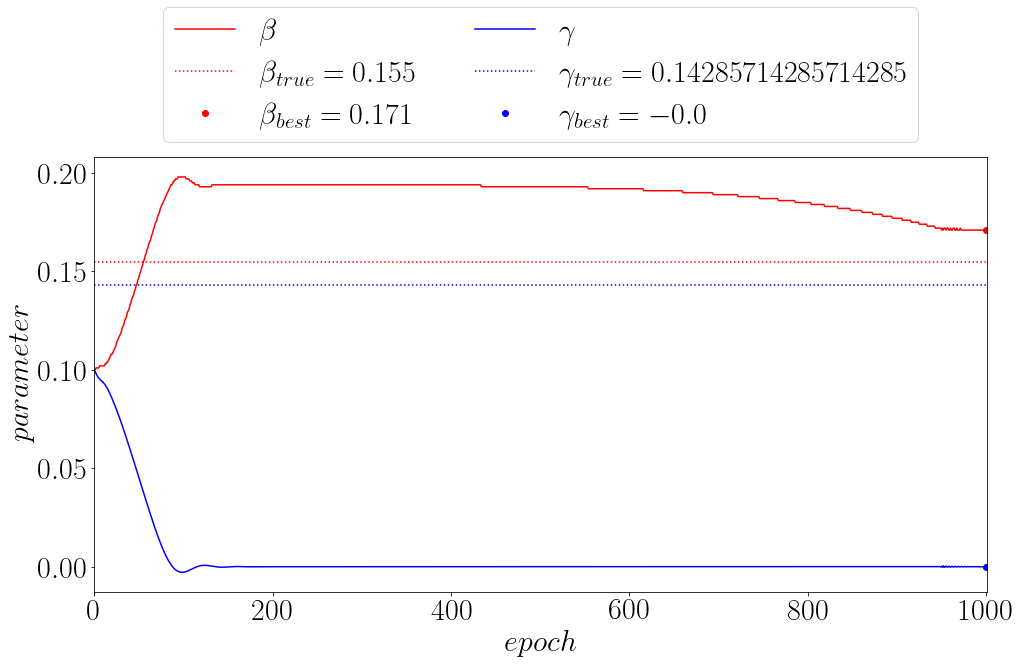

save figure to ../figures/covid/pinn/covid_pinn_param


In [12]:
plot_param_process(true_params=pinn.differential_equation.param, 
                   df_progress=pinn.get_param_history())
plot_param_process(true_params=pinn.differential_equation.param, 
                   df_progress=pinn.get_param_history(), 
                   save_path=f"{save_dir}/covid_pinn_param")

The cost per state is: 27733197.526348505.


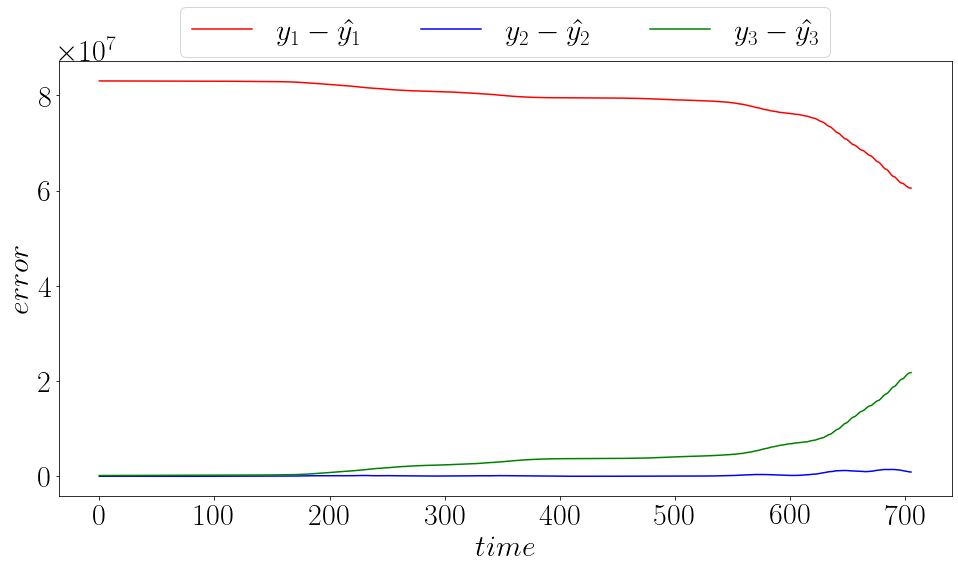

The cost per state is: 27733197.526348505.
save figure to ../figures/covid/pinn/covid_pinn_error


In [13]:
plot_error(sir.data, pinn.predict(pinn.input_data['t']), name='pinn')
plot_error(sir.data, pinn.predict(pinn.input_data['t']), name='pinn', 
           save_path=f"{save_dir}/covid_pinn_error")